In [2]:
import json
import pandas as pd
import os
import numpy as np
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import string
from nltk.stem.snowball import SnowballStemmer
from surprise import Reader, Dataset, SVD, evaluate
from sklearn.metrics import confusion_matrix
import random
pd.set_option('display.max_columns', 500)
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from surprise.model_selection import KFold
from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy

In [4]:
os.chdir("/Users/YangLyu/Dropbox/Yelp Recommendation")

In [5]:
df=pd.read_csv('df_final.csv')
df_features=pd.read_csv('df_feature.csv')

In [7]:
df.head(2)

,business_id,name,avg_stars,address,longitude,latitude,review_id,stars,text,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,3355 Las Vegas Blvd S,-115.16919,36.123183,KEAHrqN-1DV0gmuNHM6Eww,5.0,As part of a birthday celebration weekend for ...,xP1IYu2eGfxMWV9tjrurIw
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,3355 Las Vegas Blvd S,-115.16919,36.123183,6SgvNWJltnZhW7duJgZ42w,5.0,This is mine and my fiancé's favorite steakhou...,oFyOUOeGTRZhFPF9uTqrTQ


In [8]:
len(df['business_id'].unique())

4727

There are 4727 restaurants in Las Vegas in Our dataset.

In [9]:
len(df['user_id'].unique())

336464

There are 336464 users in our dataset.

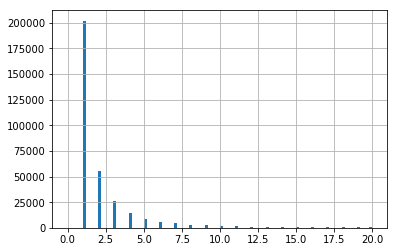

In [10]:
df['user_id'].value_counts().hist(bins = 100, range = (0,20))
plt.show()

Lots of users only write a few reviews. A few users write thousands of reviews.

Choose users with more than 10 reviews

In [11]:
re = df['user_id'].value_counts().index[df['user_id'].value_counts().values > 10]
df1=df[df['user_id'].isin(re.values)]
len(df1['user_id'].unique())

11641

There are 11641 users left.

In [12]:
df1['user_id'].value_counts().describe()

count    11641.000000
mean        25.456404
std         30.763093
min         11.000000
25%         13.000000
50%         17.000000
75%         26.000000
max       1143.000000
Name: user_id, dtype: float64

In [13]:
df_ratings = df1[['user_id', 'business_id', 'stars']] 
df_name = df1[['business_id','name']]
df_text = df1[['business_id','text']]
category=df_features[df_features['business_id'].isin(df1['business_id'].unique())]

In [14]:
df_ratings.head()

,user_id,business_id,stars
1,oFyOUOeGTRZhFPF9uTqrTQ,--9e1ONYQuAa-CB_Rrw7Tw,5.0
4,9bxdPvAhP6cuipD5s2UnCg,--9e1ONYQuAa-CB_Rrw7Tw,5.0
8,HmN7p502YMJGkBNv5bzi1w,--9e1ONYQuAa-CB_Rrw7Tw,5.0
9,3RTesI_MAwct13LWm4rhLw,--9e1ONYQuAa-CB_Rrw7Tw,4.0
10,4PIcs3X-Ro_KoczDJ3y4ZQ,--9e1ONYQuAa-CB_Rrw7Tw,5.0


#### We use precision@k and recall@k to measure our models.
#### Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
#### Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)


In [15]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


# SVD

In [16]:
reader= Reader()
data = Dataset.load_from_df(df_ratings, reader)
svd = SVD()
kf = KFold(n_splits=5)
svd_train_precision = list()
svd_train_recall = list()
svd_test_recall = list()
svd_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    svd.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = svd.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    svd_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    svd_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = svd.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    svd_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    svd_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


fold number 1
On testset,  RMSE: 1.0839
Precision: 0.7717559735036799
Recall: 0.7402646749890658
On trainset, RMSE: 0.7692
Precision: 0.959367751911334
Recall: 0.5006870804735791
fold number 2
On testset,  RMSE: 1.0770
Precision: 0.7747575112372973
Recall: 0.7381622847926135
On trainset, RMSE: 0.7688
Precision: 0.9593448443718913
Recall: 0.5001245766001313
fold number 3
On testset,  RMSE: 1.0843
Precision: 0.7743531675547795
Recall: 0.7401968132573016
On trainset, RMSE: 0.7682
Precision: 0.9589683016922801
Recall: 0.5007324457033344
fold number 4
On testset,  RMSE: 1.0820
Precision: 0.7742327100029806
Recall: 0.7387673358235166
On trainset, RMSE: 0.7671
Precision: 0.9603900008590188
Recall: 0.5015704059772933
fold number 5
On testset,  RMSE: 1.0816
Precision: 0.7745097169225447
Recall: 0.7435638275813409
On trainset, RMSE: 0.7688
Precision: 0.9577241359562324
Recall: 0.500974144815407


In [17]:
np.mean(svd_test_recall)

0.7401909872887676

In [18]:
np.mean(svd_test_precision)

0.7739218158442563

In [19]:
df_ratings[df_ratings['user_id']=="-go-R_jzvYLYngQbfKN4_A"].head()

,user_id,business_id,stars
44003,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4.0
60060,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5.0
140916,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4.0
143867,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4.0
167783,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2.0


In [20]:
example = df_ratings[df_ratings['user_id']=="-go-R_jzvYLYngQbfKN4_A"]
pre = list()
for i in range(len(example)):
    pre.append(svd.predict('-go-R_jzvYLYngQbfKN4_A',example['business_id'].iloc[i])[3])

In [22]:
b=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
b.columns= ['user_id','business_id','actual','predict']
b.head()

,user_id,business_id,actual,predict
0,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4,4.24318
1,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5,4.29275
2,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4,3.96553
3,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4,3.9082
4,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2,3.66899


In [23]:
b['relevant'] = 0 
b['relevant'][b['actual']>3.5] =1

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
b['recommend'] = 0 
b['recommend'][b['predict']>3.5] =1

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
b.head()

,user_id,business_id,actual,predict,relevant,recommend
0,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4,4.24318,1,1
1,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5,4.29275,1,1
2,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4,3.96553,1,1
3,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4,3.9082,1,1
4,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2,3.66899,0,1


In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
cm = confusion_matrix(b['relevant'], b['recommend'], labels = [1,0])
cm_df = pd.DataFrame(cm, columns = ['Recommend', 'Not Recommend'])
cm_df.index = ['Relevant','Not Relevant']
cm_df

,Recommend,Not Recommend
Relevant,17,0
Not Relevant,3,3


# item-item

In [28]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(sim_options=sim_options)
kf = KFold(n_splits=5)
ii_train_precision = list()
ii_train_recall = list()
ii_test_recall = list()
ii_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    algo.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = algo.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    ii_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    ii_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
 
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = algo.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    ii_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    ii_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


fold number 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1709
Precision: 0.7472335580790277
Recall: 0.6915237807930796
On trainset, RMSE: 1.0492
Precision: 0.9520674054348052
Recall: 0.3416270290575467
fold number 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1653
Precision: 0.7548632039236661
Recall: 0.6918034583490068
On trainset, RMSE: 1.0497
Precision: 0.9521991237866061
Recall: 0.3371857582667704
fold number 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1666
Precision: 0.7533989478039971
Recall: 0.6904340648740956
On trainset, RMSE: 1.0499
Precision: 0.9524353577871235
Recall: 0.33984690974336584
fold number 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1701
Precision: 0.7490065930149814
Recall: 0.6916359319524207
On trainset, RMSE: 1.0492
Precision: 0.9497924004237813
Re

In [100]:
np.mean(ii_test_recall)

0.7003471593404945

In [101]:
np.mean(ii_test_precision)

0.763068515183772

In [110]:
example = df_ratings[df_ratings['user_id']=="X5A_vtJh_PTQgQ5pmluCqg"]
pre = list()
for i in range(len(example)):
    pre.append(algo.predict('X5A_vtJh_PTQgQ5pmluCqg',example['business_id'].iloc[i])[3])

c=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
c.columns= ['user_id','business_id','actual','predict']
c

,user_id,business_id,actual,predict
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.49599
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,3.5212
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,3.52482
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.55013
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,3.5179
5,X5A_vtJh_PTQgQ5pmluCqg,PXShA3JZMXr2mEH3on5clw,2,3.48772
6,X5A_vtJh_PTQgQ5pmluCqg,RESDUcs7fIiihp38-d6_6g,1,3.47526
7,X5A_vtJh_PTQgQ5pmluCqg,TrN8HBHBL4-Tu7cXMDoopQ,4,3.49646
8,X5A_vtJh_PTQgQ5pmluCqg,jWv5GUtEp30OD5L5C8c2DQ,4,3.54043
9,X5A_vtJh_PTQgQ5pmluCqg,qRhxldX3lnOMJUNlytYvfQ,2,3.47291


In [111]:
c['relevant'] = 0 
c['relevant'][c['actual']>3.5] =1
c['recommend'] = 0 
c['recommend'][c['predict']>3.5] =1
c

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,business_id,actual,predict,relevant,recommend
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.49599,1,1
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,3.5212,1,1
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,3.52482,1,1
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.55013,1,1
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,3.5179,0,1
5,X5A_vtJh_PTQgQ5pmluCqg,PXShA3JZMXr2mEH3on5clw,2,3.48772,0,1
6,X5A_vtJh_PTQgQ5pmluCqg,RESDUcs7fIiihp38-d6_6g,1,3.47526,1,1
7,X5A_vtJh_PTQgQ5pmluCqg,TrN8HBHBL4-Tu7cXMDoopQ,4,3.49646,1,1
8,X5A_vtJh_PTQgQ5pmluCqg,jWv5GUtEp30OD5L5C8c2DQ,4,3.54043,1,1
9,X5A_vtJh_PTQgQ5pmluCqg,qRhxldX3lnOMJUNlytYvfQ,2,3.47291,0,0


# User-User

In [19]:
reader= Reader()
data = Dataset.load_from_df(df_ratings, reader)
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
               }
algo = KNNBasic(sim_options=sim_options)
kf = KFold(n_splits=5)
uu_train_precision = list()
uu_train_recall = list()
uu_test_recall = list()
uu_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    algo.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = algo.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    uu_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    uu_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = algo.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    uu_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    uu_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))



fold number 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1277
Precision: 0.752398922630689
Recall: 0.7670779348029448
On trainset, RMSE: 1.0632
Precision: 0.8153079170567237
Recall: 0.4616943150121082
fold number 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1260
Precision: 0.756401619241806
Recall: 0.7623932872130208
On trainset, RMSE: 1.0638
Precision: 0.8160809009162484
Recall: 0.4611774211677388
fold number 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1282
Precision: 0.7504885945548339
Recall: 0.7572729836995957
On trainset, RMSE: 1.0626
Precision: 0.816595750716268
Recall: 0.4629476420955016
fold number 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1232
Precision: 0.7548008608236921
Recall: 0.7643994501065356
On trainset, RMSE: 1.0643
Precision: 0.8182466740419438
Recall

In [20]:
np.mean(uu_test_recall)

0.7632168218363521

In [21]:
np.mean(uu_test_precision)

0.7528357064001849

In [22]:
example = df_ratings[df_ratings['user_id']=="X5A_vtJh_PTQgQ5pmluCqg"]
pre = list()
for i in range(len(example)):
    pre.append(algo.predict('X5A_vtJh_PTQgQ5pmluCqg',example['business_id'].iloc[i])[3])

d=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
d.columns= ['user_id','business_id','actual','predict']
d

,user_id,business_id,actual,predict
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.875
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,4.325
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,4.05
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.625
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,4.3264
5,X5A_vtJh_PTQgQ5pmluCqg,PXShA3JZMXr2mEH3on5clw,2,4.1
6,X5A_vtJh_PTQgQ5pmluCqg,RESDUcs7fIiihp38-d6_6g,1,4.1
7,X5A_vtJh_PTQgQ5pmluCqg,TrN8HBHBL4-Tu7cXMDoopQ,4,4.05
8,X5A_vtJh_PTQgQ5pmluCqg,jWv5GUtEp30OD5L5C8c2DQ,4,4.09875
9,X5A_vtJh_PTQgQ5pmluCqg,qRhxldX3lnOMJUNlytYvfQ,2,2.76339


In [24]:
d['relevant'] = 0 
d['relevant'][d['actual']>3.5] =1
d['recommend'] = 0 
d['recommend'][d['predict']>3.5] =1
d

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,business_id,actual,predict,relevant,recommend
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.875,1,1
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,4.325,1,1
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,4.05,1,1
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.625,1,1
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,4.3264,0,1
5,X5A_vtJh_PTQgQ5pmluCqg,PXShA3JZMXr2mEH3on5clw,2,4.1,0,1
6,X5A_vtJh_PTQgQ5pmluCqg,RESDUcs7fIiihp38-d6_6g,1,4.1,0,1
7,X5A_vtJh_PTQgQ5pmluCqg,TrN8HBHBL4-Tu7cXMDoopQ,4,4.05,1,1
8,X5A_vtJh_PTQgQ5pmluCqg,jWv5GUtEp30OD5L5C8c2DQ,4,4.09875,1,1
9,X5A_vtJh_PTQgQ5pmluCqg,qRhxldX3lnOMJUNlytYvfQ,2,2.76339,0,0


# Content Based

In [ ]:
def get_text(df):
    df_tf=df_t.groupby('business_id').sum()
    return df_tf

df_tf = get_text(df_t)

def get_wordstemming(df_tf):
    df_tf_1 = df_tf['text']
    df_tf_1=df_tf_1.str.split()
    df_tf_1 = pd.DataFrame(df_tf_1)
    df_tf_1.columns =["keywords"]
    stemmer = SnowballStemmer('english')
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: ' '.join(x))
    return df_tf_1

df_tf_1=get_wordstemming(df_tf)

def get_cosinesim(df_tf_1):
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)
    item_ids = df_ratings['business_id'].tolist()
    tfidf_matrix = vectorizer.fit_transform(df_tf_1['keywords'])
    tfidf_feature_names = vectorizer.get_feature_names()
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    return cosine_sim


In [ ]:
def get_recommendations(title):
    #df.iloc[np.where(df['name'] == title)[0][0],:]['business_id'] 
    #smd = df_tf.reset_index()
    #titles = smd['business_id']
    title=df[df['name'] == title]['business_id'].unique()[0]
    titles=df['business_id'].unique()
    
    indices = pd.Series(df.index[:len(titles)], index=titles)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:151]
    restaurant_indices = [i[0] for i in sim_scores]
    result=titles[restaurant_indices]
    result1=df[df['business_id'].isin(result)]['name'].unique().tolist()
    return result1

In [ ]:
get_recommendations('Delmonico Steakhouse')

# Hybrid

In [ ]:
def hybrid(userId, title):
    businessid = df.iloc[np.where(df['name'] == title)[0],:]["business_id"].unique()[0]
    idx=np.where(pd.DataFrame(list(enumerate(df['business_id'].unique())))[1] == businessid)[0]

    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    restaurant_indices = [i[0] for i in sim_scores]
    restaurant_id = df['business_id'].unique()[restaurant_indices]
    df[df['business_id'].isin(restaurant_id)]['name'].unique().tolist()

    scores= np.zeros(restaurant_id.shape[0])
    for i in range(restaurant_id.shape[0]):
        scores[i]= svd.predict(userId,restaurant_id[i]).est
    result= pd.DataFrame(np.hstack((pd.DataFrame(restaurant_id),    pd.DataFrame(scores))))    
    result.columns = ['business_id','scores']
    
    final=result.sort_values('scores',ascending=False)
   
    return(df[df['business_id'].isin(final["business_id"])]['name'].unique().tolist())


In [ ]:
hybrid('L8cvMZLWmM4qWTl9SkxJ8g','Delmonico Steakhouse')

# Follow the Lecture Note

In [17]:
R_df = df_ratings.pivot(index = 'user_id', columns ='business_id', values = 'stars').fillna(0)

In [18]:
X=R_df.copy()

In [19]:
R_df['user_id']= R_df.index
df1=R_df

In [20]:
X.shape

(11751, 3043)

In [21]:
df1.shape

(11751, 3044)

In [22]:
X.head()

business_id,--9e1ONYQuAa-CB_Rrw7Tw,-1vfRrlnNnNJ5boOVghMPA,-3zffZUHoY8bQjGfPSoBKQ,-8R_-EkGpUhBk55K9Dd4mg,-9YyInW1wapzdNZrhQJ9dg,-AD5PiuJHgdUcAK-Vxao2A,-ADtl9bLp8wNqYX1k3KuxA,-BS4aZAQm9u41YnB9MUASA,-Bf8BQ3yMk8U2f45r2DRKw,-BmqghX1sv7sgsxOIS2yAg,-Bv-HHUs8aHzDrdWcZHn8w,-C8sSrFqaCxp51pyo-fQLQ,-CQokjildrY7UZezXCdEBw,-CbDQXiuKzPQ0_jiUz03aw,-FNquqGseSCVMWo7KbK-Tg,-FcZY7a7qgxTUlTvwuyJnQ,-IWsoxH7mLJTTpU5MmWY4w,-JFVxwdVQfX207554dx1nw,-JfncbVURtvuzBbof40o1w,-K82LBrI3H0FVuhTbNDpRA,-LMycE26AortJDsbc8oXOg,-Le6cwbZL4tDZwNHwipfKg,-LzUYsR54hd8cCiYXTquRA,-OEIW0dO96-492qa_luxaw,-P8dGzSVhJi-5oZ-8U2y0w,-PGsEXB6DFTVKa1eDOlzWA,-QNQ4R1VgRoL4b6lC8Anrg,-Qkx7W0itbAApcG5lJuMFQ,-RJ216TTIghZshCkUlD1WQ,-U7tvCtaraTQ9b0zBhpBMA,-Uix-n4Jqo4W7ERagC5qAA,-WLrZPzjKfrftLWaCi1QZQ,-YWr1wm_NaAlgEf9TZzsMQ,-Ylpy3VyRWwubf9dysuwjQ,-_TSaVr53qiEGqMkwyEMaQ,-_yEVC3_3M6YOsamYfNFEw,-a857YYdjzgOdOjFFRsRXQ,-ed0Yc9on37RoIoG2ZgxBA,-hzQQ8tbXThpp0k5E_y1Dw,-iFvYhgysvjkxckCr42NRw,-ilCufjKjeswCLyIrCtuqQ,-mN7z9oY01Mh_-dwTyzpqg,-oUM2uISux96lMGeawHIOA,-pGO9M4JLQJHiaCOrqCgbQ,-sN_og_84rLW22CaE3cjVw,-tseCGdDvepLP8IIWtZikQ,-wCtRhzWJ40Z4F8mmg7kWg,-wDNRL4lm1UgeFLG9KcrjQ,-xbQQR_ydEJGqYzHSF4DnQ,01Ov9eDxKRY5k6ImMdiWLQ,01SiPgdiOskMC5bUJoyy_g,01VPJkcU0m8WzlA7dCEpVQ,02pL_Xj3sTO_lHcWqUcwKA,03Yt7kMeYihN_y6ptiXxyQ,03hgFWEcDg205hOCnswwiQ,03icrim6SfEQJlejDMbzsA,065c76tt1dXBNmoGBymUgQ,06MlxbtB4ZYeg_ri02RIAQ,07AZL5XenCQ_-op_onKLdw,07gh-AImcEcWQ2bew-jprg,07jQarxKd_8J_AJHD5YBqQ,0AQnRQw34IQW9-1gJkYnMA,0AZCpDQpbi83NHh9uEpggQ,0CB7YB1qRSWLQvMbHw3Fmw,0EgYXYjt2XJL4hlsKnzrcw,0EpnzIpeFvhISkxMTIv9WA,0FHfkDxKSeDuyAEeaY6X-Q,0G1y7uV7w1D2uziS4Lt_Dw,0HG02r8ri7GEFwuwmdHCyg,0Hcks5q-DgJbDlmEWolx4A,0If0W5y2M__8j0Xjlwuk0g,0InA3Ffj8MxyQV9hgsyYcQ,0LGnU7V3nepi8NUNzyQOXw,0NmTwqYEQiKErDv4a55obg,0OdZXIKQypu6vplpxFilsA,0QHMAUi6NdOUZ1ckXq0-sA,0QSnurP5Ibor2zepJmEIlw,0S4WFZJZhVeM3aAqKjLz1w,0TljdWRIDQzlp4siHQ_BAQ,0VjHFdczi6Nln_nn8bucJQ,0WPXDs4ini3D7jpiy1Daqw,0WoQQlMXVIDEgI0xNdENKA,0XEqyl_lVaJNHRKxNcjJZg,0YG_kM5caZhtwd6nbnei6A,0_VT3sTwi7gorIlU36ASmg,0_aeYE2-VbsZts_UpILgDw,0_mJttUgHIzC-NO18gcgBA,0ahghcpWQVkm4lEFwx-peA,0aw3HbxkZ4G7pkPYt10fhA,0bWLkWeIcT-EnrE7SiGEBA,0c6PQILCLwRZ8FIB4AEsGw,0d0i0FaJq1GIeW1rS2D-5w,0dr1FgqQSEMbaTu9SDqiIg,0eJG77JOkyMIBhc4Xbuqfw,0eZHVYDyACtVVOIgoBlV3g,0gTTGuA6uEmMhLhfJi0hqA,0gWg-kqRLEQbhui8b_v2Xw,0i9S0BejjRv0ZDwdO9XymA,0jtRI7hVMpQHpUVtUy4ITw,0keht9nVTliinChbGWWkkg,0nlocywsFHQmEt8_xbHNiw,0p27EjcNwTI7Ey4K_MNPww,0qPNeqLuKE88rKbIbSZDpg,0q_BHpxbikVtPRRLRu-U0g,0qet57CmMA5qUm6gPFUTpg,0tnZj3GkhKxPd9hT3HXt5A,0uR48n5SYcLE_DLcjONZPg,0ueq5zB3NqLbh93KYYNIHQ,0w3BdEOxvwKTpypwbN5kiQ,0wW9PasC8pw8SY7rlY3ZKw,0xdpv5CPpbUUch7JKBG98Q,0xtBEP5zCu1153SoqqemLw,0xvdC8F0HmFpAFkJk6nXLg,0xzmIBsJQc5eUNLucFrZ0Q,0yjLZZx708uJbierAonqQg,0zoXYHq82haayMaV952jEQ,12f7GOkkC0GZRMif-fidhQ,16Fplxu-OwVmTEFxQAUP4g,16tWXenJ1wTqugXJU7yiZg,19S0gFtg5GTX6CkiApJiAQ,19umlhmVB9O3njIBfRAe8g,1CP8aJa8ILlfM5deroar0Q,1CR2ddUcjYYwRd5JLtiRrw,1CTapYK3FHvpiJaQhOaaIw,1CWMNSTRMejdSyXBG2chNg,1CaM8eIvl41l4f3V-V-cAw,1DP5vHxJzCDbgawv0WC3yA,1Df5WnLX3DqN6ymlhqznaQ,1FAvxOUOGGyZoYNlAXACag,1JgaRBX0oiRsvEhHF3ZMjw,1KhBzrqmU164bss64jR5uA,1M1A-s6BbnzK3eURw01rZQ,1ME-zOtZ9HApzJUOpR0-vQ,1MrSwj8i2VEBHdp3IsWCpQ,1SCETxRnwaYo2aBC3fi4SA,1SE9f6TEV5XhnTuuK01xwA,1SqLPgnZEVeVYDM-AuoFhg,1Tak6Q-IlkDrdmLwrEZeSg,1UdRVfBlE3unETOu7BDCvw,1UvrUFk3BXAmueL1KQaKPQ,1V-mRUpVnIRq6GYymT_uyw,1VTezD8PLosh-FeNxSRQ7g,1Vvxx-9AoINg8TJXOZgEHg,1WBVqmo7tgF0z0eGf4fPhQ,1XeI5PX5RxvFlaAHBKRUYA,1Z5S_Lkcl6vA3ZvrAG91TA,1ZJz840L496LAmQdeDv0WA,1ZnVfS-qP19upP_fwOhZsA,1aj4TG0eFq6NaPBKk6bK7Q,1bALsE6aZE23mGV2WPxN_g,1diuAK7FMn93WxlK-ndJhA,1g29d62cEojB-7mX7p8AzQ,1jpYP-JNOEYCMIzP4OlGuQ,1nM-ES-xVqL0yQGTCwtd-Q,1qTx9z8RMz7RIYKAfnpZ0A,1uDUisf3ro5V3vC60cxfFw,217u7Wad7y90x4el26-TIw,21sGRVR7HEs_t6PdB9tGMw,25PEf9-e8_7phdV7JjOHhA,25wTaO0_Rk-GLb4k2uMs0Q,296PZdxSrtH08EUwCsOKMw,2B46bRpDh49eDyjXGhL_ZQ,2BbFeotL85cIaBjSq1SWiA,2DydwQRkIutHarWT_o1L0Q,2HxaDXZmAOH6LiuzGgNdPA,2I_qSTehoUFsDNjaqCVxlA,2IvrdAb6zdxr3ZqplqJHbg,2LL-pWxdM_rvnaIpNxezsQ,2LNnIARy-lGmrlEMZSxZ1w,2LZGeJy8qByYKB71ML-jcw,2Mp53KxlGeZJkodTuqpVow,2PS9kBbuJcmBhcNp-D62uA,2Q9Mgkc7iFHuKoD_z7kJkQ,2RFe9vDTz

In [23]:
user_user = 1-pairwise_distances(X, metric="cosine")
item_item = 1-pairwise_distances(X.T, metric="cosine")

In [24]:
user_user.shape


(11751, 11751)

In [226]:
item_item.shape


(3043, 3043)

In [227]:
df_items = pd.DataFrame(item_item,columns=X.columns,index=X.columns)
df_users = pd.DataFrame(user_user,columns=R_df.index,index=R_df.index)


In [228]:
corr=df_items[0:20][df_items.columns[0:20]]


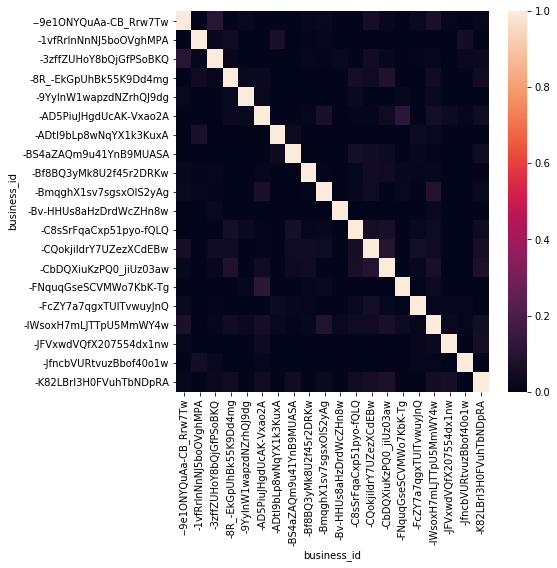

In [229]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
# Create a placeholder items for closes neighbours to an item
data_neighbours = pd.DataFrame(index=df_items.columns,columns=range(1,11))
 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(df_items.columns)):
    data_neighbours.ix[i,:10] = df_items.ix[0:,i].order(ascending=False)[:10].index

In [ ]:
data_neighbours.head(6).ix[:6,1:4]

In [232]:
df[df['business_id'] == '-8R_-EkGpUhBk55K9Dd4mg']['name'].unique()

array(['Sin City Thai Restaurant'], dtype=object)

In [233]:
df[df['business_id'] == 'Y9kXVlU4xPfSZvkZH6C_2Q']['name'].unique()

array(['Naked City Tavern'], dtype=object)

In [234]:
df_users.head()

user_id,---1lKK3aKOuomHnwAkAow,--RlSfc-QmcHFGHyX6aVjA,--WLHsm-AC4jcol2gOkmCQ,--ZNfWKj1VyVElRx6-g1fg,-05XqtNjcBq19vh2CVJN8g,-0HhZbPBlB1YZx3BhAfaEA,-0MXmdIs75oSWmp8XlQKIw,-1ksPJf0Eppmxj9ZNCkMRw,-21ooEUDqBkCF0hr94Pvgg,-267Yx8RmdP6io2-qI4UcQ,-2UOdDlzg7XLuUuyOrldhA,-2gOxVWcnBr5DclrrsWXCA,-3s52C4zL_DHRK0ULG6qtg,-4JDJeFS0YAYSiSvIshGLQ,-50XWnmQGqBgEI-9ANvLlg,-594af_E7Z9VVjQc9pJK3g,-5McD_r7-sbeZeuIAvnOJg,-5ye1ya0wRQhNRF9NfQ1fA,-6sK3CL1g1OP1FMawX2hxA,-7IMRsmV-Gt7KAK3yivZGQ,-7bM_DeL2Kj2CuYuVDsLNg,-8BrIcsVPbGhv6EAEqbBfA,-8EnCioUmDygAbsYZmTeRQ,-8FDlhUsu5_lVONV_aOnGA,-8MEYFYRHzGEgqBsDV6m2A,-8bfKCvDClxD3iKX9o7J5w,-8eWVKFS0XaktfEaSxMWSw,-8syaSLDbMXW2F2FApVgig,-95gDpECFDSjWEL1AIrkAA,-9B3OS9cH8jIwIjYdqn8xQ,-9I98YbNQnLdAmcYfb324Q,-9da1xk7zgnnfO1uTVYGkA,-9tvXZauwIIpyy9J-moV6A,-AGXyI_K8StzQ7CGehQ2tQ,-AXCpsIGp5Wq1e6wVX4YlA,-Ak9LVDH8GYyWtIMnNo5Ug,-ApvB2uyNYkLCvSfwgLF7g,-B731Wh1510uXX9eC1orQQ,-BevLRnJhh9JeIT2g5I3mQ,-C-l8EHSLXtZZVfUAUhsPA,-C9TzyciiJwct30Mwm_o9Q,-CXdtsZGsM2FBvju5eTAlA,-Cr_udl8Bf-35w5E_5NoHA,-CxzWyvRj3b3tvFdelf38w,-DlNrkkd5iUXwdfmSGx5ew,-E4Smvof6DdBHCnZNyxNMw,-EJorVxe7h2GSxdiRyMmDA,-ELBgtqnuDHoARN3g1n8hQ,-FFqZupwGHf-vrsUHMr_vw,-FjLaUdIRV3I0Pv8i-ICfQ,-Fy91nyOFqPv9M_MaZ4W2g,-HAHTQeOzHX5TCDb7qs9Yw,-HLWgeG3dM_SlcS-vvjEqA,-HcirMcpUDd3GvexCOCCzg,-HdbkVr80PlnsNSLbgW-7g,-IM1qwYck6nqKizjCzR_ww,-Ia1lWvBNdgGySyB2VSgNQ,-IcuwptriARnTWf_EaqgrA,-JvZ2KzL8VCkQI1ZHVrCow,-K3I3SCFvPS_Aw8B4gBtVQ,-KeEr7ZLjbOskY6GGE54hQ,-LEJFq5RC0rQAG831uYRKg,-LUmRqjZdJGLB45pDaqdWA,-Lcp9BDlDDo7j3aIGJWjYg,-LhU9PZZKaP_xFa_rjo9jQ,-Lq86w0tSzzm-SPG8UORsA,-M9PGXdiElWSm4Edm0lEqg,-MqEeaw31xIn1U8mSPWG-Q,-N0xFiL7wxv07F11bfLOvQ,-NHgxN7b9H4g9IIDA1XTVg,-NIopdD4X-FX7V0ucTg2Vg,-NbeVN5tnwdyYAvdNkKMjw,-Ng6kNjzZee-hT-RZYg_Eg,-Ox7QPz0G56GOzT0ex-f5Q,-PAOMIe7lqq1x5GB1pcKMg,-PHC1ulwHkY4LEmMqmFwPg,-PP2PBPpbrYdITLHJzNb4A,-PUQqO7rbjmdQ0KwYcbGAg,-PXJEs_9T0lRKpssxf3otg,-PbPi3wYwpLHs6bM7pwFrA,-PfcLYFMW9ZXc1DEWSqw-g,-Q4HGzcXSCeiqvmY2mg-aQ,-Q4e76IjAqixOEKXkWYxlQ,-Q4lgMSfhoSiVj62dvzUPw,-QViqz6QGfMLUYLY73lysg,-QX-SOFGJHCeSH2CMxr0BQ,-QeO_KlWX19xZUmuv0eXjw,-QmmHtp57b3zT79APvRONA,-R-Z97qJK3E1S8lQSda8Gg,-RA9NLalwmRTOX_8UMHnVQ,-RApyq06DMBii7ovXtQnfw,-R_hd3xKlnUIi_m-IZsY9Q,-Rdc_Yz1WL16lBv7S3PUMg,-SISdpV3Q202NW50EISxWQ,-SWRw9-1ARVKLAWE0Sxw1Q,-SjQXQd-IRfOdUdYYwWGOQ,-TMDrC66dvClx5Z7Hdzrfw,-Tj4e-zW67MXj9Z7-Zkzpw,-U81P8KvkEbl0-aJBGwetQ,-URAJU5BQAM2F1_SNna81g,-UtSFRnsdUgC_R1OzGZVhA,-VNv58eLhbQpz787rcD8VA,-VOylYXNq7sG6As966yTxA,-Vrb0dmE3AxJuJ0dyVY4NA,-WCWlsVGhxaLQMfpKuuKhw,-WYbVngIGDQ81MY12UtwnA,-Wd_SCRLmBeRH8c-TmJ55A,-X8saOIinN36j-Z5_s767Q,-XN6b7pqV2lghQgrIgu3vQ,-XPUcrd6F2wHVUITFAlOYA,-XouWRfq24qMx37oJcXXmg,-XvB5TvlGahyamqIsJO-fg,-YLiMJ0xeWxqny9O9YKzoA,-YV1yESQXqR3vpIgBjKDsw,-Z0uXJn_uP3U0h-e31sTKw,-ZCGdGLtETgNEaOtqHQmSQ,-ZEKvTTWmSCdRJam9YfB1Q,-ZQknHztP6Kpf2DKtCF51w,-_lw9mjGf-92eC90JPW2_w,-aV7azrzW2rlAm6G4DA-cw,-b4O2A-ntjSla1bPnfxU1Q,-bg2NzPGRxVbyftAzaTLiQ,-bh9TmtLO6w7-o07Zr7GiA,-bj4evSejxRDuvYnmcGNrg,-brNcfzn5EaIYORDy4Xj8g,-bt7uzN1JCGauBR64cNupg,-c9G-JHNqrPY0_UU9j7BJA,-d1-LUHXVOw2t3bdJHg26Q,-dD3Oo1tDZYUSecu8Gxq9Q,-dDBNkNgZYyHagrYW60wxg,-dxDfwn30JSChQmO1Bmpeg,-e372MSRHw6vvxliWcxBOA,-eVBjD2-3MJzIyJwwtcGsg,-edOrcdWGnNLodyAEadUKA,-f--l4tZ2F7S0SmoO6wyaA,-fUARDNuXAfrOn4WLSZLgA,-fVKgpmSu0tDnf_xBPqU4A,-fzk0slIjoFQD1eWjx1uWw,-fzqv_NhAkmh4Wu0F9qxDw,-gN7r8iOBKGeh4LJkn2QeQ,-gQZ1BfxbXEN8XuoYBJd2g,-gQm-IoK2_BMEMx9OgtQnw,-gSz76_bKNJsKM2adr12yw,-gTz-C55z7gObvo-R5zzZg,-gc1y2tmDyOJXnMbV_wKpA,-gfC7auUsRN2KqTBzHMBZg,-gi3QTLxpER5LqqPXYEsMw,-go-R_jzvYLYngQbfKN4_A,-guyVbrMJxVeBcfdRQc6xw,-gzqF2ucnXwHf64_k2Hoxg,-h3OxE2YbWzFXVkBhYtJTw,-hFSXulXh22Es29Y4F4cgQ,-hYYjAXSAa657rY0ANtTGQ,-hxUwfo3cMnLTv-CAaP69A,-iBUZFbX7m2IrnraAhhQHg,-j-8EX-ebLXybLAdDQOGzw,-j3PQicmtfQz6RyaK0S1-w,-jL7hLAAwOnCAWKQlL9Wew,-jpu5KX95HLWJdztLq53uQ,-k5yFUChotBMGQgHdFZvLQ,-kO6984fXByyZm3_6z2JYg,-kRQLEDxrEBVNXImyAt_ug,-khrbWmeaZDZ6hzTgJ4HpQ,-ki-qIZHP4zZ2D49-b8ZzA,-lCMo6oeRPQVOBu-27qsQQ,-lLEwwXKARlLhAd05tfmVA,-lORwg9gjWI6q3-2-J7dLw,-lWYDxgOF99Hpxc0hrAuFQ,-lh59ko3dxChBSZ9U7LfUw,-mGJPKC0owz3HTrrZfgFUg,-mXobpJ3z3X6nMriCklbog,-mzS8ZrsN5vIhAM22gcS3Q,-ne-7caCLAk2j3kD7tzBGw,-nuKSqlNyZv7A

In [235]:
df_users[0:10][df_users.columns[0:10]]

user_id,---1lKK3aKOuomHnwAkAow,--RlSfc-QmcHFGHyX6aVjA,--WLHsm-AC4jcol2gOkmCQ,--ZNfWKj1VyVElRx6-g1fg,-05XqtNjcBq19vh2CVJN8g,-0HhZbPBlB1YZx3BhAfaEA,-0MXmdIs75oSWmp8XlQKIw,-1ksPJf0Eppmxj9ZNCkMRw,-21ooEUDqBkCF0hr94Pvgg,-267Yx8RmdP6io2-qI4UcQ
user_id,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,1.000000,0.000000,0.000000,0.000000,0.000000,0.057295,0.091958,0.058649,0.000000,0.073985
--RlSfc-QmcHFGHyX6aVjA,0.000000,1.000000,0.000000,0.082318,0.000000,0.046397,0.000000,0.000000,0.051188,0.052424
--WLHsm-AC4jcol2gOkmCQ,0.000000,0.000000,1.000000,0.038680,0.000000,0.000000,0.029159,0.000000,0.144315,0.000000
--ZNfWKj1VyVElRx6-g1fg,0.000000,0.082318,0.038680,1.000000,0.000000,0.000000,0.000000,0.012560,0.152286,0.030945
-05XqtNjcBq19vh2CVJN8g,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.074954,0.000000,0.018548,0.033922
-0HhZbPBlB1YZx3BhAfaEA,0.057295,0.046397,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010046
-0MXmdIs75oSWmp8XlQKIw,0.091958,0.000000,0.029159,0.000000,0.074954,0.000000,1.000000,0.000000,0.000000,0.000000
-1ksPJf0Eppmxj9ZNCkMRw,0.058649,0.000000,0.000000,0.012560,0.000000,0.000000,0.000000,1.000000,0.000000,0.020568
-21ooEUDqBkCF0hr94Pvgg,0.000000,0.051188,0.144315,0.152286,0.018548,0.000000,0.000000,0.000000,1.000000,0.083128


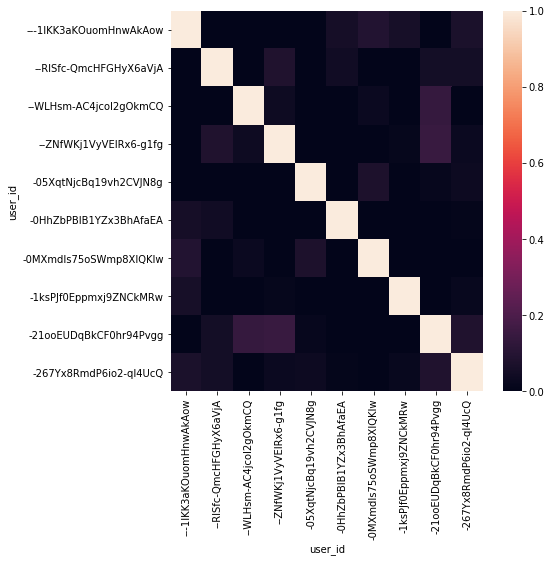

In [236]:
import seaborn as sns
corr = df_users[0:10][df_users.columns[0:10]]
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [104]:
users=df1['user_id'].values


In [105]:
df_user_recs=df_users.apply(lambda row : users[np.argsort(row)[::-1]],axis=1)

In [106]:
df_nearest_neighbors_all=df_user_recs[df_user_recs.columns[0:]]

In [107]:
df_nearest_neighbors_5 = df_nearest_neighbors_all[df_nearest_neighbors_all.columns[0:5]]


In [108]:
df_nearest_neighbors_5.head()


user_id,---1lKK3aKOuomHnwAkAow,--RlSfc-QmcHFGHyX6aVjA,--ZNfWKj1VyVElRx6-g1fg,-267Yx8RmdP6io2-qI4UcQ,-2gOxVWcnBr5DclrrsWXCA
user_id,,,,,
---1lKK3aKOuomHnwAkAow,---1lKK3aKOuomHnwAkAow,4Zqh0-Db39qpGEHCIll9hw,Ii1PkdRpONUNwKC3lmhl1A,r_-YhOstIUFhl_KZWZxflA,G4pBy0nzqqkKgJEHrDNcWQ
--RlSfc-QmcHFGHyX6aVjA,--RlSfc-QmcHFGHyX6aVjA,tH0uKD-vNwMoEc3Xk3Cbdg,ZyGrNTbnab8N3kmesYaQBQ,zHzvPBcXuzyGSAPzc0k2Bg,ldqh2aWLTW6D2RHDCj_2TA
--ZNfWKj1VyVElRx6-g1fg,--ZNfWKj1VyVElRx6-g1fg,11k3A-_Ifz_86LHvkGRgoQ,8HyODWHxD1Vmq5O7HeJe-A,pnfVIB7UhvCQ7X2K0Q2XIw,VvYC7DUlWds5H2fs8nyeUQ
-267Yx8RmdP6io2-qI4UcQ,-267Yx8RmdP6io2-qI4UcQ,eZZyuJDouIg4p-GYB3PV_A,N3oNEwh0qgPqPP3Em6wJXw,kwIhn1_cnQeUaLN0CuWWHw,n86B7IkbU20AkxlFX_5aew
-2gOxVWcnBr5DclrrsWXCA,-2gOxVWcnBr5DclrrsWXCA,jVsWBaVdvVYT9mMYvM0Zjg,RJVpaFHx3MwynTM8TNjz0A,3Kn4WUjRW4mktpYa0El3IQ,gt5NfNrG8e_4TNBZeyBbfw


In [109]:
df1.head()


business_id,--9e1ONYQuAa-CB_Rrw7Tw,-3zffZUHoY8bQjGfPSoBKQ,-8R_-EkGpUhBk55K9Dd4mg,-9YyInW1wapzdNZrhQJ9dg,-AD5PiuJHgdUcAK-Vxao2A,-ADtl9bLp8wNqYX1k3KuxA,-Bf8BQ3yMk8U2f45r2DRKw,-BmqghX1sv7sgsxOIS2yAg,-C8sSrFqaCxp51pyo-fQLQ,-FNquqGseSCVMWo7KbK-Tg,-FcZY7a7qgxTUlTvwuyJnQ,-IWsoxH7mLJTTpU5MmWY4w,-JFVxwdVQfX207554dx1nw,-JfncbVURtvuzBbof40o1w,-K82LBrI3H0FVuhTbNDpRA,-Le6cwbZL4tDZwNHwipfKg,-LzUYsR54hd8cCiYXTquRA,-OEIW0dO96-492qa_luxaw,-P8dGzSVhJi-5oZ-8U2y0w,-PGsEXB6DFTVKa1eDOlzWA,-Qkx7W0itbAApcG5lJuMFQ,-RJ216TTIghZshCkUlD1WQ,-U7tvCtaraTQ9b0zBhpBMA,-WLrZPzjKfrftLWaCi1QZQ,-YWr1wm_NaAlgEf9TZzsMQ,-Ylpy3VyRWwubf9dysuwjQ,-_TSaVr53qiEGqMkwyEMaQ,-_yEVC3_3M6YOsamYfNFEw,-a857YYdjzgOdOjFFRsRXQ,-ed0Yc9on37RoIoG2ZgxBA,-iFvYhgysvjkxckCr42NRw,-ilCufjKjeswCLyIrCtuqQ,-mN7z9oY01Mh_-dwTyzpqg,-oUM2uISux96lMGeawHIOA,-sN_og_84rLW22CaE3cjVw,-wCtRhzWJ40Z4F8mmg7kWg,-wDNRL4lm1UgeFLG9KcrjQ,-xbQQR_ydEJGqYzHSF4DnQ,01Ov9eDxKRY5k6ImMdiWLQ,01SiPgdiOskMC5bUJoyy_g,01VPJkcU0m8WzlA7dCEpVQ,02pL_Xj3sTO_lHcWqUcwKA,03icrim6SfEQJlejDMbzsA,065c76tt1dXBNmoGBymUgQ,07AZL5XenCQ_-op_onKLdw,07gh-AImcEcWQ2bew-jprg,0AQnRQw34IQW9-1gJkYnMA,0CB7YB1qRSWLQvMbHw3Fmw,0EgYXYjt2XJL4hlsKnzrcw,0FHfkDxKSeDuyAEeaY6X-Q,0G1y7uV7w1D2uziS4Lt_Dw,0Hcks5q-DgJbDlmEWolx4A,0InA3Ffj8MxyQV9hgsyYcQ,0LGnU7V3nepi8NUNzyQOXw,0NmTwqYEQiKErDv4a55obg,0OdZXIKQypu6vplpxFilsA,0QHMAUi6NdOUZ1ckXq0-sA,0QSnurP5Ibor2zepJmEIlw,0S4WFZJZhVeM3aAqKjLz1w,0VjHFdczi6Nln_nn8bucJQ,0WPXDs4ini3D7jpiy1Daqw,0WoQQlMXVIDEgI0xNdENKA,0XEqyl_lVaJNHRKxNcjJZg,0YG_kM5caZhtwd6nbnei6A,0_VT3sTwi7gorIlU36ASmg,0_aeYE2-VbsZts_UpILgDw,0_mJttUgHIzC-NO18gcgBA,0aw3HbxkZ4G7pkPYt10fhA,0bWLkWeIcT-EnrE7SiGEBA,0c6PQILCLwRZ8FIB4AEsGw,0d0i0FaJq1GIeW1rS2D-5w,0dr1FgqQSEMbaTu9SDqiIg,0gTTGuA6uEmMhLhfJi0hqA,0gWg-kqRLEQbhui8b_v2Xw,0jtRI7hVMpQHpUVtUy4ITw,0nlocywsFHQmEt8_xbHNiw,0p27EjcNwTI7Ey4K_MNPww,0qPNeqLuKE88rKbIbSZDpg,0q_BHpxbikVtPRRLRu-U0g,0uR48n5SYcLE_DLcjONZPg,0ueq5zB3NqLbh93KYYNIHQ,0w3BdEOxvwKTpypwbN5kiQ,0xdpv5CPpbUUch7JKBG98Q,0xtBEP5zCu1153SoqqemLw,0xvdC8F0HmFpAFkJk6nXLg,0xzmIBsJQc5eUNLucFrZ0Q,0zoXYHq82haayMaV952jEQ,16Fplxu-OwVmTEFxQAUP4g,16tWXenJ1wTqugXJU7yiZg,19S0gFtg5GTX6CkiApJiAQ,19umlhmVB9O3njIBfRAe8g,1CP8aJa8ILlfM5deroar0Q,1CR2ddUcjYYwRd5JLtiRrw,1CTapYK3FHvpiJaQhOaaIw,1CWMNSTRMejdSyXBG2chNg,1DP5vHxJzCDbgawv0WC3yA,1Df5WnLX3DqN6ymlhqznaQ,1FAvxOUOGGyZoYNlAXACag,1JgaRBX0oiRsvEhHF3ZMjw,1KhBzrqmU164bss64jR5uA,1MrSwj8i2VEBHdp3IsWCpQ,1SCETxRnwaYo2aBC3fi4SA,1SE9f6TEV5XhnTuuK01xwA,1SqLPgnZEVeVYDM-AuoFhg,1Tak6Q-IlkDrdmLwrEZeSg,1UdRVfBlE3unETOu7BDCvw,1UvrUFk3BXAmueL1KQaKPQ,1V-mRUpVnIRq6GYymT_uyw,1Vvxx-9AoINg8TJXOZgEHg,1WBVqmo7tgF0z0eGf4fPhQ,1Z5S_Lkcl6vA3ZvrAG91TA,1ZJz840L496LAmQdeDv0WA,1ZnVfS-qP19upP_fwOhZsA,1aj4TG0eFq6NaPBKk6bK7Q,1bALsE6aZE23mGV2WPxN_g,1g29d62cEojB-7mX7p8AzQ,1jpYP-JNOEYCMIzP4OlGuQ,217u7Wad7y90x4el26-TIw,21sGRVR7HEs_t6PdB9tGMw,25wTaO0_Rk-GLb4k2uMs0Q,296PZdxSrtH08EUwCsOKMw,2B46bRpDh49eDyjXGhL_ZQ,2HxaDXZmAOH6LiuzGgNdPA,2I_qSTehoUFsDNjaqCVxlA,2IvrdAb6zdxr3ZqplqJHbg,2LL-pWxdM_rvnaIpNxezsQ,2LNnIARy-lGmrlEMZSxZ1w,2Mp53KxlGeZJkodTuqpVow,2RFe9vDTzyBkF4mvsFDDow,2SfSzEd3B7WimeZac23zhg,2Wl4o7l54I-EtxtaDpOTzA,2XkVexeY_8zyc9nriSElQg,2Y0-nrSZNsLRStyupZgM7g,2YBO1LEKIgyle0uX50u15Q,2bK1ng2mnRdtTh_BDNGmIg,2dCnTMv3Hh-fM8bOjYS4Xw,2g_auUWw7c3c2CUTgVqI8Q,2hSIeCX2cV-chFcBBXrZZA,2hyciWHsqnbqdEkUvO3KuQ,2iTsRqUsPGRH1li1WVRvKQ,2lPLbTenaBH3SGHgpwM54A,2m4092MsMzEHkuxodaj6-g,2rvBPUBtQU0WfcOAHLQWRQ,2sdU3Fq3Wv2XQycJoJQArg,2sx52lDoiEtef7xgPCaoBw,2weQS-RnoOBhb1KsHKyoSQ,310Eyru1zsZ9K7BA-bgPQw,31cOttU_tML5b6eLLXZfsQ,32JWhoH-Kiu1wRFTvHvW9Q,33Tr0eRki1Yamzleu4GMdw,34PMhyoSQHVd4Lr7slzUcA,364hhL5st0LV16UcBHRJ3A,3BCsAgo_1i4xMuTyLKMLRQ,3FlWR_osNPb8dcqLgHebHw,3GEEy7RP6e4bT4LAiWFMFQ,3GfdCuI0YCc5U3rLLLPHUw,3Gt3xskppi9jZuTrwrhLNg,3IwCop28R1_L5jMv6AkL8Q,3Jq5LfJ5fmJ5KmuA6VHmzw,3LWsVfsSmb_Nzbi2YQ-NIA,3QcTqsdxQBlSndBdMJBRhQ,3Qe4M3JNs7yIRXP13g-NYA,3WRvQJS9GIBubGxbHMzX2g,3XE-poXz9CeDao-Q7pqkTw,3ZHyw0d8mk0HOEP7v4fW1A,3ajqOW9A7VhResA08I7RTg,3cHL1r5w2oLYH-veijtweA,3cg4pKBL8DTFXCtZ5y9V4g,3fPIRTnBhd81MixgS9YoMQ,3fT1kcQ-MVEImGHa3hll5w,3h5jLa-kbHg0cL7v9En0Lg,3kdSl5mo9dWC4clrQjEDGg,3m2XZFVraCiqjgLxHi5MdA,3nf-a84p8

In [110]:
X.shape

(3609, 2188)

In [64]:
item_item = 1-pairwise_distances(X[0:8000].T, metric="cosine")
df_items = pd.DataFrame(item_item,columns=X.columns,index=X.columns)

In [70]:
df_items.shape

(2637, 2637)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if sys.path[0] == '':


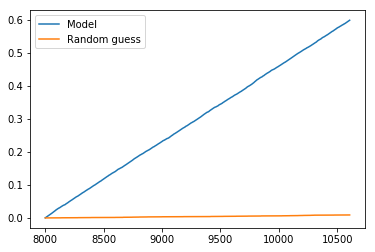

In [76]:
recall=[]
guesses = 3
recall_total = 0
recall_guess = 0

recall_guesses = []

for n in range(8000,X.shape[0]):
    user = np.append(X[n:n+1].values[0][0:2000],np.zeros(X.shape[1]-2000))
    user_prefs = df_items.dot(user/np.sum(user))
    
    user_prefs.sort()
    already_liked=df_items[df_items.columns[np.where(X[n:n+1].values[0]>0)][0:5]].columns.values

    test_data=df_items[df_items.columns[np.where(X[n:n+1].values[0]>0)][5:]].columns.values
    
    user_suggestions =[s for s in user_prefs.index[::-1][0:guesses] if s not in already_liked]
    
    correct = [c for c in user_suggestions if c in test_data]
    gue=random.sample(range(len(user_prefs.index)), min(guesses,len(user_prefs)))
    guess_list = [g for g in user_prefs.index[gue]  if g in test_data]

    recall_total = recall_total + float(len(correct))
    recall_guess = recall_guess + float(len(guess_list))
   
    recall.append(recall_total)
    recall_guesses.append(recall_guess)
plt.plot(range(8000,X.shape[0]),recall/(np.array(guesses)*(X.shape[0]-8000)),label='Model')
plt.plot(range(8000,X.shape[0]),recall_guesses/(np.array(guesses)*(X.shape[0]-8000)),label='Random guess')
plt.legend()

range(8000, 10607)

In [26]:
item_item.shape

(3043, 3043)